## 1. Importacion de librerias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

import xgboost as xgb

# Importar utilidades compartidas entre notebooks
from utils import (
    load_data,
    split_data_by_weeks,
    evaluate_model,
    save_metrics,
    plot_all_diagnostics,
    FEATURE_COLS,
    TARGETS,
    HORIZONS
)

# Configurar estilo de graficas
plt.style.use('seaborn-v0_8-notebook')

# Configuracion de directorios
OUTPUT_DIR = 'output/2_xgboost'
MODEL_NAME = 'XGBoost'



# Crear directorio de salida si no existePath(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)


## 2. Carga de datos

In [ ]:
# Cargar dataset completo
df = load_data()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Datos cargados: 20,436,599 registros
Estaciones: 677
Periodo: 2025-05-02 00:00:00-06:00 a 2025-11-30 22:50:00-06:00
Features incluyen lags y trends precalculados: ocu_lag_1,2,6,12,138,144 y ocu_trend_1,2,6,12
Verificacion: No hay valores NaN en features ni targets


In [ ]:
# Dividir datos en train, validacion y test por semanas completas
train_df, val_df, test_df = split_data_by_weeks(df)


Total de semanas disponibles en el dataset: 31
Zona horaria utilizada: America/Mexico_City
Primera semana: 2025-W18
Ultima semana: 2025-W48

Semanas eliminadas del inicio: 1
  Primera semana eliminada: 2025-W18
  Ultima semana eliminada: 2025-W18

Semanas a utilizar: 30 (de 2025-W19 a 2025-W48)

Semanas asignadas:
  Train: 2025-W19 a 2025-W40 (22 semanas)
  Val:   2025-W41 a 2025-W44 (4 semanas)
  Test:  2025-W45 a 2025-W48 (4 semanas)

Division de datos:
  Entrenamiento: 14,854,057 registros (22 semanas)
  Validacion:    2,611,866 registros (4 semanas)
  Pruebas:       2,678,212 registros (4 semanas)

Rangos de fechas:
  Train: 2025-05-05 00:00:00-06:00 a 2025-10-05 23:50:00-06:00
  Val:   2025-10-06 00:00:00-06:00 a 2025-11-02 23:50:00-06:00
  Test:  2025-11-03 00:00:00-06:00 a 2025-11-30 22:50:00-06:00


## 3. Preparacion de datos

In [ ]:
# Extraer features (XGBoost no requiere escalado)
X_train = train_df[FEATURE_COLS].values
X_val = val_df[FEATURE_COLS].values
X_test = test_df[FEATURE_COLS].values

print(f"Features: {len(FEATURE_COLS)}")
print(f"\nDimensiones:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")


Features: 42

Dimensiones:
  X_train: (14854057, 42)
  X_val:   (2611866, 42)
  X_test:  (2678212, 42)


## 4. Configuracion de hiperparametros

In [ ]:
# Hiperparametros optimizados para XGBoost
XGBOOST_PARAMS = {
    'objective': 'reg:squarederror',
    'eval_metric': ['rmse', 'mae'],
    'max_depth': 12,
    'learning_rate': 0.013538653188957502,
    'n_estimators': 1000,
    'subsample': 0.8681213431491254,
    'colsample_bytree': 0.7335511485510692,
    'min_child_weight': 3,
    'reg_alpha': 1.4694966652098598,
    'reg_lambda': 0.5969892383310387,
    'n_jobs': -1,
    'verbosity': 1,
    'early_stopping_rounds': 50
}

print("Hiperparametros configurados:")
for key, value in XGBOOST_PARAMS.items():
    print(f"  {key}: {value}")


Hiperparametros configurados:
  objective: reg:squarederror
  eval_metric: ['rmse', 'mae']
  max_depth: 12
  learning_rate: 0.013538653188957502
  n_estimators: 1000
  subsample: 0.8681213431491254
  colsample_bytree: 0.7335511485510692
  min_child_weight: 3
  reg_alpha: 1.4694966652098598
  reg_lambda: 0.5969892383310387
  n_jobs: -1
  verbosity: 1
  early_stopping_rounds: 50


## 5. Entrenamiento de modelos

Se entrena un modelo XGBoost independiente para cada horizonte de prediccion, utilizando early stopping basado en el conjunto de validacion para evitar overfitting.

In [ ]:
# Diccionarios para almacenar modelos entrenados e historiales
models = {}
training_history = {}

# Entrenar un modelo independiente para cada horizonte temporal
for target, horizon in zip(TARGETS, HORIZONS):
    print(f"\n{'='*60}")
    print(f"Entrenando modelo para horizonte {horizon} min ({target})")
    # Obtener variables objetivo (deltas de ocupacion)
    y_train = train_df[target].values
    y_val = val_df[target].values
    # Crear modelo XGBoost con hiperparametros configurados
    model = xgb.XGBRegressor(**XGBOOST_PARAMS)
    
    # Entrenar con early stopping usando conjunto de validacion
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100
    # Almacenar modelo e historial de entrenamiento
    models[target] = model
    training_history[target] = model.evals_result()
    
    # Obtener mejor iteracion segun early stopping
    best_iteration = model.best_iteration
    # Evaluar modelo en conjunto de validacion
    y_val_pred = model.predict(X_val)
    mae_val = np.mean(np.abs(y_val - y_val_pred))
    rmse_val = np.sqrt(np.mean((y_val - y_val_pred) ** 2))
    print(f"Validacion - MAE: {mae_val:.6f}, RMSE: {rmse_val:.6f}")
    
    # Guardar modelo entrenado
    joblib.dump(model, f'{OUTPUT_DIR}/model_{horizon}min.pkl')
print(f"\nModelos guardados en: {OUTPUT_DIR}")

print(f"\nModelos guardados en: {OUTPUT_DIR}")
print(f"\nModelos guardados en: {OUTPUT_DIR}")
print(f"\nModelos guardados en: {OUTPUT_DIR}")

print(f"\nModelos guardados en: {OUTPUT_DIR}")





Entrenando modelo para horizonte 20 min (ocu_delta_20)
[0]	validation_0-rmse:0.08063	validation_0-mae:0.04165	validation_1-rmse:0.08167	validation_1-mae:0.04252
[100]	validation_0-rmse:0.07407	validation_0-mae:0.04115	validation_1-rmse:0.07529	validation_1-mae:0.04199
[167]	validation_0-rmse:0.07284	validation_0-mae:0.04109	validation_1-rmse:0.07433	validation_1-mae:0.04202

Mejor iteracion: 117
Validacion - MAE: 0.041978, RMSE: 0.074941

Entrenando modelo para horizonte 40 min (ocu_delta_40)
[0]	validation_0-rmse:0.11253	validation_0-mae:0.06312	validation_1-rmse:0.11367	validation_1-mae:0.06405
[100]	validation_0-rmse:0.09845	validation_0-mae:0.05895	validation_1-rmse:0.09991	validation_1-mae:0.05987
[200]	validation_0-rmse:0.09525	validation_0-mae:0.05809	validation_1-rmse:0.09747	validation_1-mae:0.05933
[300]	validation_0-rmse:0.09377	validation_0-mae:0.05756	validation_1-rmse:0.09677	validation_1-mae:0.05919
[400]	validation_0-rmse:0.09278	validation_0-mae:0.05714	validation_1-r

## 6. Curvas de entrenamiento

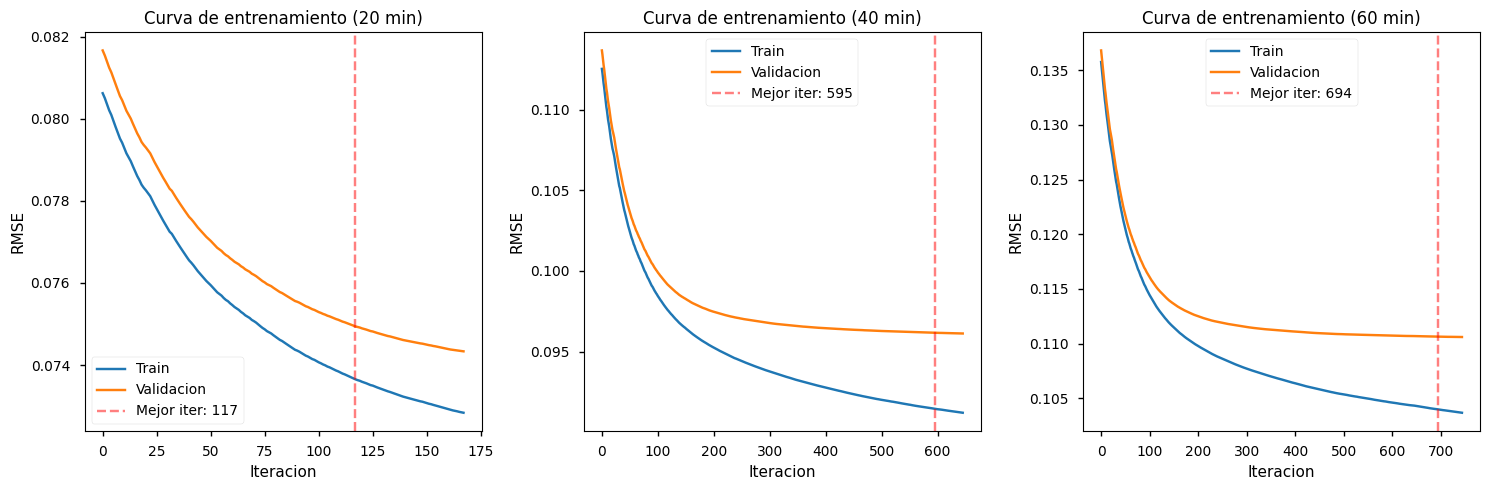

In [ ]:
# Visualizar curvas de entrenamiento y validacion para cada horizonte
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (target, horizon) in enumerate(zip(TARGETS, HORIZONS)):
    history = training_history[target]
    
    epochs = range(len(history['validation_0']['rmse']))
    
    axes[i].plot(epochs, history['validation_0']['rmse'], label='Train')
    axes[i].plot(epochs, history['validation_1']['rmse'], label='Validacion')
    
    # Marcar mejor iteracion
    best_iter = models[target].best_iteration
    axes[i].axvline(x=best_iter, color='red', linestyle='--', alpha=0.5, 
                    label=f'Mejor iter: {best_iter}')
    
    axes[i].set_xlabel('Iteracion')
    axes[i].set_ylabel('RMSE')
    axes[i].set_title(f'Curva de entrenamiento ({horizon} min)')
    axes[i].legend()

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()


## 7. Evaluacion en conjunto de pruebas

In [ ]:
# Generar predicciones para cada horizonte en el conjunto de pruebas
y_true_dict = {}
y_pred_dict = {}

for target in TARGETS:
    y_true_dict[target] = test_df[target].values
    y_pred_dict[target] = models[target].predict(X_test)

print(f"Registros en test: {len(test_df):,}")


Registros en test: 2,678,212


In [ ]:
import pickle

# Cargar MAE del modelo baseline para calcular Skill Score
baseline_file = 'output/0_persistence/baseline_mae.pkl'
with open(baseline_file, 'rb') as f:
    baseline_mae_dict = pickle.load(f)

print(f"Baseline MAE cargado desde: {baseline_file}")

# Evaluar el modelo y calcular metricas
capacity = test_df['capacity'].values
metrics_df = evaluate_model(y_true_dict, y_pred_dict, capacity=capacity, baseline_mae_dict=baseline_mae_dict)

print("\nMetricas en conjunto de pruebas:")
print("=" * 70)
print(metrics_df.to_string(index=False))
print("=" * 70)
print("\nMAE_bikes: error promedio en numero de bicicletas")
print("SS (Skill Score): mejora respecto al baseline (0=igual, >0=mejor, <0=peor)")


Baseline MAE cargado desde: output/0_persistence/baseline_mae.pkl

Metricas en conjunto de pruebas:
 Horizonte      MAE     RMSE  MAE_bikes       SS
        20 0.041347 0.074085   1.069571 0.003976
        40 0.058771 0.095327   1.523410 0.060071
        60 0.070679 0.109794   1.835944 0.098405

Nota: MAE_bikes es el error promedio en numero de bicicletas
      SS (Skill Score) mide mejora respecto al baseline (0=igual, >0=mejor, <0=peor)


In [ ]:
# Guardar metricas en archivo CSV
save_metrics(metrics_df, OUTPUT_DIR)


Metricas guardadas en: output/2_xgboost/metrics.csv


## 8. Visualizacion de resultados

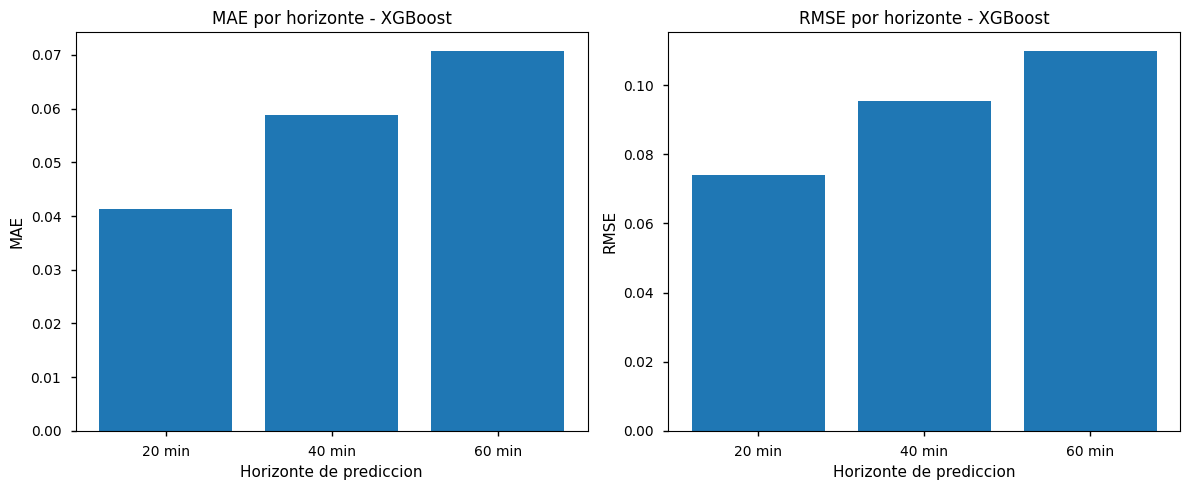

In [ ]:
# Generar graficos de MAE y RMSE por horizonte temporal
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# MAE por horizonte
axes[0].bar(metrics_df['Horizonte'].astype(str) + ' min', metrics_df['MAE'])
axes[0].set_xlabel('Horizonte de prediccion')
axes[0].set_ylabel('MAE')
axes[0].set_title('MAE por horizonte - XGBoost')

# RMSE por horizonte
axes[1].bar(metrics_df['Horizonte'].astype(str) + ' min', metrics_df['RMSE'])
axes[1].set_xlabel('Horizonte de prediccion')
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE por horizonte - XGBoost')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/metrics_by_horizon.png', dpi=300, bbox_inches='tight')
plt.show()


## 9. Importancia de features

XGBoost proporciona metricas de importancia de variables basadas en gain, que mide la mejora promedio que aporta cada feature en los splits del modelo.

In [ ]:
# Extraer importancia de features del modelo de 20 minutos
model_20 = models['ocu_delta_20']

# Obtener importancia basada en gain (mejora promedio en splits)
importance = model_20.get_booster().get_score(importance_type='gain')

# Crear dataframe con nombres de features y sus importancias
importance_df = pd.DataFrame([
    {'Feature': FEATURE_COLS[int(k.replace('f', ''))], 'Importance': v}
    for k, v in importance.items()
])
importance_df = importance_df.sort_values('Importance', ascending=False)

print("Top 15 features mas importantes (horizonte 20 min):")
print(importance_df.head(15).to_string(index=False))


Top 15 features mas importantes (horizonte 20 min):
              Feature  Importance
 station_netflow_rate    7.097254
                  ocu    5.985634
            ocu_lag_1    2.657367
station_turnover_rate    1.595810
         is_operating    1.578235
          ocu_lag_138    1.513597
             time_cos    0.991767
             time_sin    0.943977
          ocu_trend_2    0.831289
            ocu_lag_6    0.759611
            ocu_lag_2    0.749007
              day_sin    0.667120
          ocu_trend_1    0.663881
           is_weekend    0.651204
          ocu_trend_6    0.595541


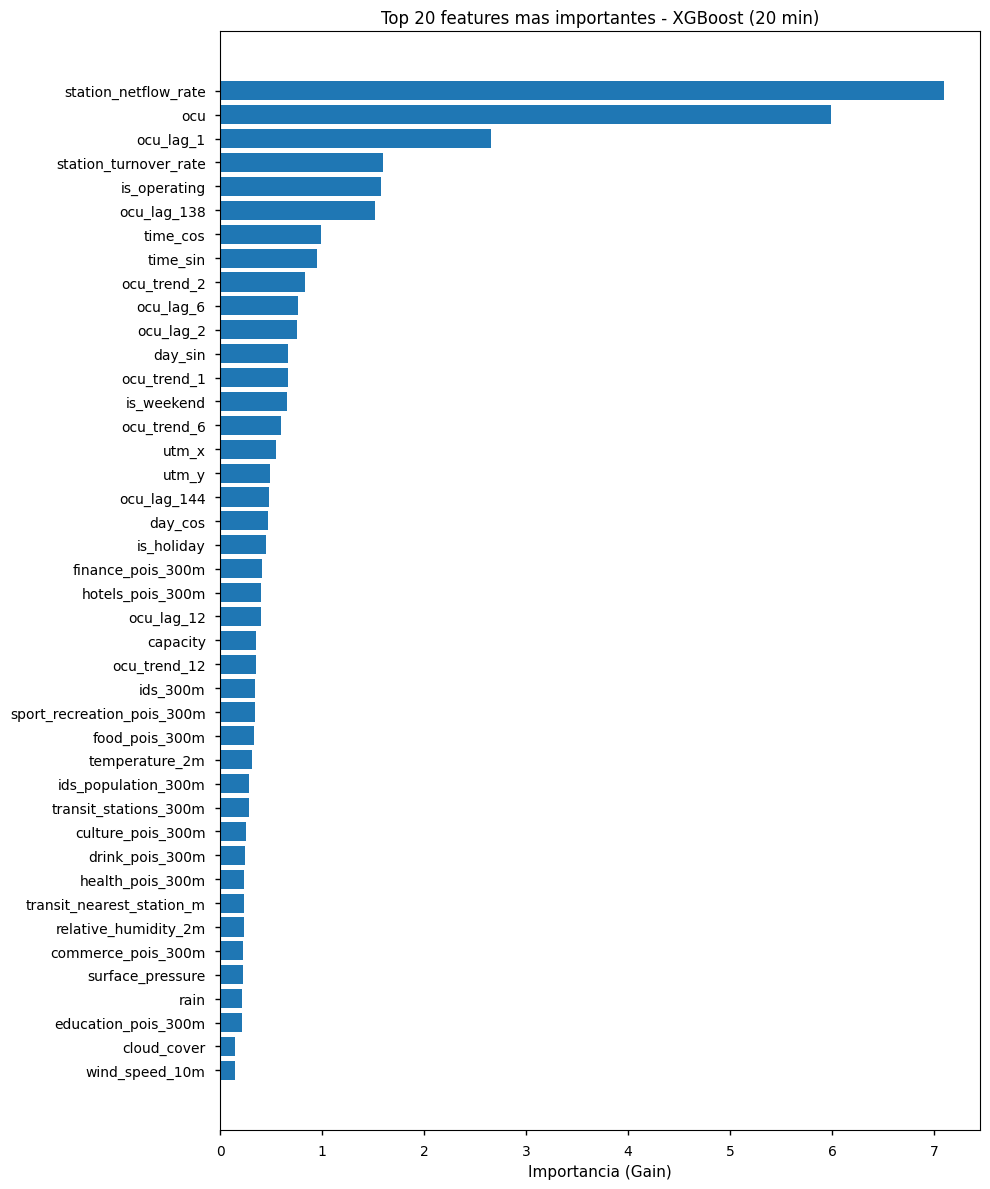

In [ ]:
# Visualizar las 20 features mas importantes
fig, ax = plt.subplots(figsize=(10, 12))

# Seleccionar top 20 features
top_features = importance_df.head(20)

ax.barh(range(len(top_features)), top_features['Importance'].values)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Importancia (Gain)')
ax.set_title('Top 20 features mas importantes - XGBoost (20 min)')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/feature_importance_20min.png', dpi=300, bbox_inches='tight')
plt.show()


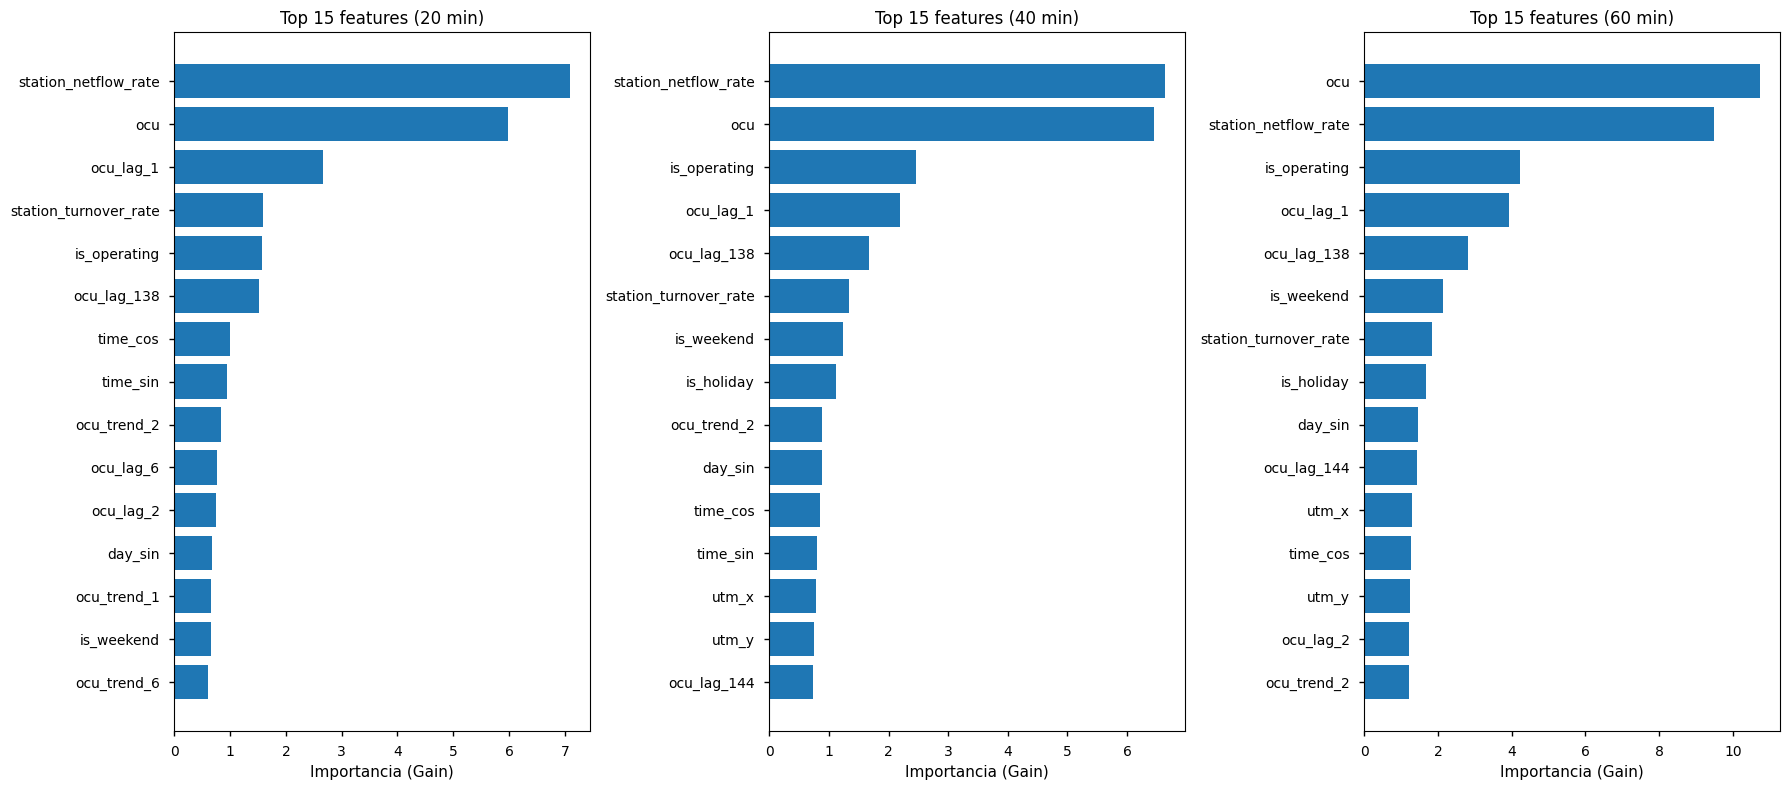

In [ ]:
# Comparar importancia de features entre los tres horizontes temporales
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

for i, (target, horizon) in enumerate(zip(TARGETS, HORIZONS)):
    model = models[target]
    importance = model.get_booster().get_score(importance_type='gain')
    
    importance_df = pd.DataFrame([
        {'Feature': FEATURE_COLS[int(k.replace('f', ''))], 'Importance': v}
        for k, v in importance.items()
    ])
    importance_df = importance_df.sort_values('Importance', ascending=False).head(15)
    
    axes[i].barh(range(len(importance_df)), importance_df['Importance'].values)
    axes[i].set_yticks(range(len(importance_df)))
    axes[i].set_yticklabels(importance_df['Feature'].values)
    axes[i].invert_yaxis()
    axes[i].set_xlabel('Importancia (Gain)')
    axes[i].set_title(f'Top 15 features ({horizon} min)')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Guardar importancia de features para cada horizonte en archivos CSV
for target, horizon in zip(TARGETS, HORIZONS):
    model = models[target]
    importance = model.get_booster().get_score(importance_type='gain')
    
    importance_df = pd.DataFrame([
        {'Feature': FEATURE_COLS[int(k.replace('f', ''))], 'Importance': v}
        for k, v in importance.items()
    ])
    importance_df = importance_df.sort_values('Importance', ascending=False)
    importance_df.to_csv(f'{OUTPUT_DIR}/feature_importance_{horizon}min.csv', index=False)

print(f"Importancia de features guardada en: {OUTPUT_DIR}")


Importancia de features guardada en: output/2_xgboost


## 10. Graficas de diagnostico

In [ ]:
# Generar graficas de diagnostico (residuos, predicho vs real, etc)
print("Generando graficas de diagnostico...")
plot_all_diagnostics(
    df_test=test_df,
    y_true_dict=y_true_dict,
    y_pred_dict=y_pred_dict,
    output_dir=OUTPUT_DIR,
    model_name=MODEL_NAME
)


Generando graficas de diagnostico...
  Estaciones seleccionadas:
    Alta actividad: 082
    Baja actividad: 244
    Actividad media: 392
  Generando graficas para horizonte 20 min...
  Generando graficas para horizonte 40 min...
  Generando graficas para horizonte 60 min...
Graficas guardadas en: output/2_xgboost


## 11. Resumen

In [ ]:
# Mostrar resumen de configuracion y resultados del modelo
print("=" * 60)
print("RESUMEN - MODELO XGBOOST")
print("=" * 60)
print(f"\nFeatures utilizadas: {len(FEATURE_COLS)}")
print(f"Escalado: No requerido para XGBoost")
print(f"Early stopping rounds: {XGBOOST_PARAMS['early_stopping_rounds']}")
print(f"\nHiperparametros principales:")
print(f"  max_depth: {XGBOOST_PARAMS['max_depth']}")
print(f"  learning_rate: {XGBOOST_PARAMS['learning_rate']}")
print(f"  n_estimators: {XGBOOST_PARAMS['n_estimators']}")
print(f"\nMejores iteraciones:")
for target, horizon in zip(TARGETS, HORIZONS):
    print(f"  {horizon} min: {models[target].best_iteration}")
print(f"\nConjuntos de datos:")
print(f"  Entrenamiento: {len(train_df):,} registros")
print(f"  Validacion:    {len(val_df):,} registros")
print(f"  Pruebas:       {len(test_df):,} registros")
print(f"\nMetricas en conjunto de pruebas:")
for _, row in metrics_df.iterrows():
    print(f"  Horizonte {int(row['Horizonte'])} min: MAE={row['MAE']:.6f}, RMSE={row['RMSE']:.6f}, MAE_bikes={row['MAE_bikes']:.2f}")
print(f"\nArchivos guardados en: {OUTPUT_DIR}")
print("=" * 60)


RESUMEN - MODELO XGBOOST

Features utilizadas: 42
Escalado: No requerido
Early stopping rounds: 50

Hiperparametros principales:
  max_depth: 12
  learning_rate: 0.013538653188957502
  n_estimators: 1000

Mejores iteraciones:
  20 min: 117
  40 min: 595
  60 min: 694

Conjuntos de datos:
  Entrenamiento: 14,854,057 registros
  Validacion:    2,611,866 registros
  Pruebas:       2,678,212 registros

Metricas en conjunto de pruebas:
  Horizonte 20 min: MAE=0.041347, RMSE=0.074085, MAE_bikes=1.07
  Horizonte 40 min: MAE=0.058771, RMSE=0.095327, MAE_bikes=1.52
  Horizonte 60 min: MAE=0.070679, RMSE=0.109794, MAE_bikes=1.84

Archivos guardados en: output/2_xgboost
